In [ ]:
!pip install opencv-python

In [2]:
import numpy as np
import cv2

from IPython.display import HTML
import sys
import matplotlib.pyplot as plt
from IPython import display



In [3]:

def image_binary(img, sobel_kernel=9, mag_thresh=(10, 255), s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = hls[:, :, 1]
    s_channel = hls[:, :, 2]

    # Binary matrixes creation
    sobel_binary = np.zeros(shape=gray.shape, dtype=bool)
    s_binary = sobel_binary
    combined_binary = s_binary.astype(np.float32)

    # Sobel Transform
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = 0  # cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_abs = np.abs(sobelx ** 2 + sobely ** 2)
    sobel_abs = np.uint8(255 * sobel_abs / np.max(sobel_abs))

    sobel_binary[(sobel_abs > mag_thresh[0]) & (sobel_abs <= mag_thresh[1])] = 1

    # Threshold color channel
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds

    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.uint8(255 * combined_binary / np.max(combined_binary))

    # ---------------- MASKED IMAGE --------------------
    offset = 100
    mask_polyg = np.array([[(0 + offset, img.shape[0]),
                            (img.shape[1] / 2.5, img.shape[0] / 1.65),
                            (img.shape[1] / 1.8, img.shape[0] / 1.65),
                            (img.shape[1], img.shape[0])]],
                          dtype=int)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask_img = np.zeros_like(combined_binary)
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    # Applying polygon
    cv2.fillPoly(mask_img, mask_polyg, ignore_mask_color)
    masked_edges = cv2.bitwise_and(combined_binary, mask_img)

    return masked_edges


def warp(img, src, dst):
    src = np.float32([src])
    dst = np.float32([dst])

    return cv2.warpPerspective(img, cv2.getPerspectiveTransform(src, dst),
                               dsize=img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)


In [4]:

def sliding_windown(img_w):
    histogram = np.sum(img_w[int(img_w.shape[0] / 2):, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_w, img_w, img_w)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = int(img_w.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_w.shape[0] - (window + 1) * window_height
        win_y_high = img_w.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
                nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
                nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    return left_fit, right_fit



In [5]:

img = cv2.imread('d.jpg')
cv2.imshow('output',img)

print(img.shape)

(720, 1280, 3)


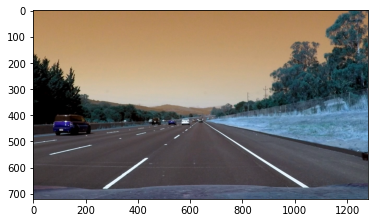

In [6]:
plt.imshow(img)

In [7]:

def fit_from_lines(left_fit, right_fit, img_w):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
            nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
            (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
            nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


def draw_lines(img, img_w, left_fit, right_fit, perspective):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_w).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # color_warp_center = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # cv2.fillPoly(color_warp_center, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, perspective[1], perspective[0])
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.2, 0)

    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(0, 255, 0), thickness=25)
    cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 255, 0), thickness=25)
    newwarp_lines = warp(color_warp_lines, perspective[1], perspective[0])

    result = cv2.addWeighted(result, 1, newwarp_lines, 1, 0)

    return result


def cal_radius_and_offset(left_fit, right_fit, img, result):
    # ----- Radius Calculation ------ #

    img_height = img.shape[0]
    y_eval = img_height

    ym_per_pix = 30 / 720.  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Calculate the new radii of curvature
    # substitute in the equation of the radius with the LEFT lane polynomial to get LEFT lane line curvature radius
    left_curverad = ((1 + (2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit[0])
    # substitute in the equation of the radius with the RIGHT lane polynomial to get RIGHT lane line curvature radius
    right_curverad = ((1 + (2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit[0])

    # Calculate vehicle offset from lane center, in meters
    # Calculate vehicle center offset in pixels
    bottom_y = img.shape[0] - 1
    bottom_x_left = left_fit[0] * (bottom_y ** 2) + left_fit[1] * bottom_y + left_fit[
        2]  # sub in left lane line polynomial with bottom y
    bottom_x_right = right_fit[0] * (bottom_y ** 2) + right_fit[1] * bottom_y + right_fit[
        2]  # sub in right lane line polynomial with bottom y
    vehicle_offset = img.shape[1] / 2 - (
                bottom_x_left + bottom_x_right) / 2  # average of bottom_x_left and bottom_x_right is the center of the lane
    # subtract the lane center from the car center to get the offset
    # Convert pixel offset to meters
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix
    vehicle_offset = np.abs(vehicle_offset)
    # writing lane curvature and vehical offset on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(result, 'Lane Curvature: {:.0f} m'.format(np.mean([left_curverad, right_curverad])),
                # calculate the mean of the left and right lane lines curvature
                (500, 620), font, fontSize, fontColor, 2)  # radius to get the lane center curvature
    # radius, and print it on the image
    # print the car offset on the image
    cv2.putText(result, 'Vehicle offset: {:.4f} m'.format(vehicle_offset), (500, 650), font, fontSize, fontColor, 2)
    return result



In [8]:

def add_image(thresh, final, y):
    # resize image ( grayscale)
    dim = (200, 200)
    resized_im = cv2.resize(thresh, dim, interpolation=cv2.INTER_AREA)
    # add 3rd dimension to grayscale image
    resized = np.reshape(resized_im, (200, 200, 1))
    height, width, dim = resized.shape  # get dimensions
    # resized[0] = np.delete(resized[0], 0, 0)
    offset = np.array(
        (y, 50))  # top-left point from which to insert the smallest image. height first, from the top of the window
    final[offset[0]:offset[0] + height, offset[1]:offset[1] + width] = resized
    return final


In [9]:

def input_image(inp, outp):
    clp = cv2.imread(inp)

    first_run = True
    MOV_AVG_LENGTH = 5
    gleft_fit = gright_fit = None
    i = 0
    while i < 1:

        img = clp.copy()
        blur = cv2.GaussianBlur(img, (5, 5), 0)

        img_b = image_binary(blur, 15, (20, 255))

        line_dst_offset = 200
        src = [595, 452], \
              [685, 452], \
              [1110, img_b.shape[0]], \
              [220, img_b.shape[0]]

        dst = [src[3][0] + line_dst_offset, 0], \
              [src[2][0] - line_dst_offset, 0], \
              [src[2][0] - line_dst_offset, src[2][1]], \
              [src[3][0] + line_dst_offset, src[3][1]]

        img_w = warp(img_b, src, dst)

        if first_run:
            left_fit, right_fit = sliding_windown(img_w)
            mov_avg_left = np.array([left_fit])
            mov_avg_right = np.array([right_fit])
            first_run = False


        else:
            left_fit, right_fit = fit_from_lines(left_fit, right_fit, img_w)

            if abs(left_fit[1] - right_fit[1]) == 0:
                first_run = True
            else:
                first_run = False
            mov_avg_left = np.append(mov_avg_left, np.array([left_fit]), axis=0)
            mov_avg_right = np.append(mov_avg_right, np.array([right_fit]), axis=0)

        left_fit = np.array([np.mean(mov_avg_left[::-1][:, 0][0:MOV_AVG_LENGTH]),
                             np.mean(mov_avg_left[::-1][:, 1][0:MOV_AVG_LENGTH]),
                             np.mean(mov_avg_left[::-1][:, 2][0:MOV_AVG_LENGTH])])
        right_fit = np.array([np.mean(mov_avg_right[::-1][:, 0][0:MOV_AVG_LENGTH]),
                              np.mean(mov_avg_right[::-1][:, 1][0:MOV_AVG_LENGTH]),
                              np.mean(mov_avg_right[::-1][:, 2][0:MOV_AVG_LENGTH])])

        if mov_avg_left.shape[0] > 1000:
            mov_avg_left = mov_avg_left[0:MOV_AVG_LENGTH]
        if mov_avg_right.shape[0] > 1000:
            mov_avg_right = mov_avg_right[0:MOV_AVG_LENGTH]

        final = draw_lines(img, img_w, left_fit, right_fit, perspective=[src, dst])

        # let the image open for infinite amount of time
        clp = final
        i = i + 1
    print(i)
    plt.imshow(clp)


1


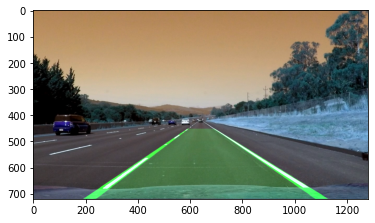

In [10]:
input_image('d.jpg','out.jpg')

In [11]:
    #Read image
    img = cv2.imread('d.jpg')

In [12]:
        first_run = True
        MOV_AVG_LENGTH = 5
        gleft_fit = gright_fit = None
        
        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, gray = cv2.threshold(grayscale, 130, 255, cv2.THRESH_BINARY_INV)

        img_b = image_binary(img, 15, (18, 255))

        line_dst_offset = 200
        src = [595, 452], \
              [685, 452], \
              [1110, img_b.shape[0]], \
              [220, img_b.shape[0]]

        dst = [src[3][0] + line_dst_offset, 0], \
              [src[2][0] - line_dst_offset, 0], \
              [src[2][0] - line_dst_offset, src[2][1]], \
              [src[3][0] + line_dst_offset, src[3][1]]

        img_w = warp(img_b, src, dst)

        if first_run:
            left_fit, right_fit = sliding_windown(img_w)
            mov_avg_left = np.array([left_fit])
            mov_avg_right = np.array([right_fit])
            first_run = False

        else:
            left_fit, right_fit = fit_from_lines(left_fit, right_fit, img_w)

            if abs(left_fit[1] - right_fit[1]) == 0:
                first_run = True
            else:
                first_run = False
            mov_avg_left = np.append(mov_avg_left, np.array([left_fit]), axis=0)
            mov_avg_right = np.append(mov_avg_right, np.array([right_fit]), axis=0)

        left_fit = np.array([np.mean(mov_avg_left[::-1][:, 0][0:MOV_AVG_LENGTH]),
                             np.mean(mov_avg_left[::-1][:, 1][0:MOV_AVG_LENGTH]),
                             np.mean(mov_avg_left[::-1][:, 2][0:MOV_AVG_LENGTH])])
        right_fit = np.array([np.mean(mov_avg_right[::-1][:, 0][0:MOV_AVG_LENGTH]),
                              np.mean(mov_avg_right[::-1][:, 1][0:MOV_AVG_LENGTH]),
                              np.mean(mov_avg_right[::-1][:, 2][0:MOV_AVG_LENGTH])])

        if mov_avg_left.shape[0] > 1000:
            mov_avg_left = mov_avg_left[0:MOV_AVG_LENGTH]
        if mov_avg_right.shape[0] > 1000:
            mov_avg_right = mov_avg_right[0:MOV_AVG_LENGTH]

        final = draw_lines(img, img_w, left_fit, right_fit, perspective=[src, dst])

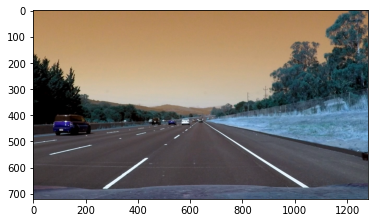

In [13]:
 plt.imshow(img)

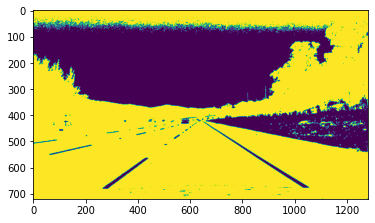

In [14]:
plt.imshow(gray)

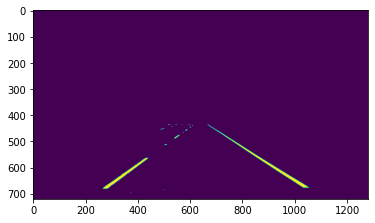

In [15]:
plt.imshow(img_b)

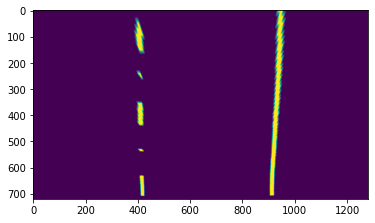

In [16]:
plt.imshow(img_w)